In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from scipy import stats

In [67]:
#We load in the data that has a three year average for the dev aid but not for the emigration
migVSmoney=pd.read_csv("FinalData/MigVsMoney_Cont_Reg31.csv")
migVSmoney.head()

,Recipient,Report Year,3yrAverage Money,3yrAverage Money per cap,Emigration per cap over all OECD,Emigration sum over all OECD countries,Continent,Region
0,Afghanistan,1996.0,8.471000e+07,18.218528,0.000716,12765.0,ASIA,SouthernAsia
1,Afghanistan,1997.0,1.530267e+08,15.158800,0.000715,13137.0,ASIA,SouthernAsia
2,Afghanistan,1998.0,2.553067e+08,14.351002,0.000645,12173.0,ASIA,SouthernAsia
3,Afghanistan,1999.0,2.446233e+08,13.321431,0.000613,11885.0,ASIA,SouthernAsia
4,Afghanistan,2000.0,2.410600e+08,12.825481,0.000824,16550.0,ASIA,SouthernAsia


In [68]:
#we get a list of all continents, regions and countries
uniquecontinents=migVSmoney.Continent.unique()

uniqueregions=migVSmoney.Region.unique()
uniquecountries=migVSmoney.Recipient.unique()

print(uniquecontinents)
print(uniqueregions)

['ASIA' 'EUROPE' 'AFRICA' 'AMERICA' 'CARRIBEANS' 'OCEANIA']
['SouthernAsia' 'SouthernEurope' 'NorthernAfrica' 'MiddleAfrica'
 'SouthernAmerica' 'WesternAsia' 'EasternEurope' 'CentralAmerica'
 'WesternAfrica' 'SouthernAfrica' 'EasternAfrica' 'SouthernEastAsia'
 'Carribeans' 'EasternAsia' 'Oceania' 'CentralAsia']


In [69]:
#we define the upper and the lower quartile for all measures
migVSmoneyQ=migVSmoney.quantile([.25, .75])
migVSmoneyQ


,Report Year,3yrAverage Money,3yrAverage Money per cap,Emigration per cap over all OECD,Emigration sum over all OECD countries
0.25,2001.0,1.196200e+08,23.160813,0.000205,1011.0
0.75,2011.0,7.612367e+08,121.051608,0.002270,18971.0


In [70]:
#now we pick the ones that we are interested about: 
#the one for immigration per capita and the one for 3yr average of money spent
preMigrationUPboundary=migVSmoneyQ.iloc[1][-2]
preMigrationLOWboundary=migVSmoneyQ.iloc[0][-2]
preMoneyUPboundary=migVSmoneyQ.iloc[1][1]
preMoneyLOWboundary=migVSmoneyQ.iloc[0][1]
print(preMigrationLOWboundary,preMigrationUPboundary)
print(preMoneyLOWboundary, preMoneyUPboundary)

0.000205035620182 0.00227027027027
119620000.0 761236666.667


In [71]:
#we define the upper and lower boundaries for our outlier window by the formula:
#http://www.mathwords.com/o/outlier.htm
#(3rd quartile-1st quartile)*1.5
IQRmoneyX=(preMoneyUPboundary-preMoneyLOWboundary)*1.5
IQRmigX=(preMigrationUPboundary-preMigrationLOWboundary)*1.5
MoneyUPboundary=preMoneyUPboundary+IQRmoneyX
MoneyLOWboundary=preMoneyLOWboundary-IQRmoneyX
MigrationLOWboundary=preMigrationLOWboundary-IQRmigX
MigrationUPboundary=preMigrationUPboundary+IQRmigX
print(MigrationLOWboundary,MigrationUPboundary)
print(MoneyLOWboundary, MoneyUPboundary)
print(IQRmoneyX,IQRmigX)

-0.00289281635495 0.0053681222454
-842805000.0 1723661666.67
962425000.0 0.00309785197513


In [72]:
#we check what is the length of the dataframe before we strip it of the outliers
df=migVSmoney
len(migVSmoney)


2549

In [73]:
#now we get rid of the outliers

migVSmoneyQ = migVSmoney[(migVSmoney.ix[:,2] > MoneyLOWboundary) & (migVSmoney.ix[:,2] < MoneyUPboundary) ]
df = migVSmoneyQ[(migVSmoneyQ.ix[:,4] > MigrationLOWboundary) & (migVSmoneyQ.ix[:,4] < MigrationUPboundary)]
len(df)

2002

In [74]:
#Shapiro-Wilk
x = df.ix[:,2]
y = df.ix[:,4]

shapiro_results = scipy.stats.shapiro(x)

print(shapiro_results)
shapiro_results = scipy.stats.shapiro(y)

print(shapiro_results)

(0.873929500579834, 1.7607084270254406e-37)
(0.8023210763931274, 3.923635700109488e-44)


In [75]:
#Levene's test
x = df.ix[:,2]
y = df.ix[:,4]

levene_results = scipy.stats.levene(x,y)

print(levene_results)


LeveneResult(statistic=2190.7862614526994, pvalue=0.0)


In [76]:
#Finally we run the regression
import statsmodels.api as sm

X = df.ix[:,2]
Y = df.ix[:,4]

X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.012
Model:                                          OLS   Adj. R-squared:                  0.012
Method:                               Least Squares   F-statistic:                     24.60
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           7.67e-07
Time:                                      20:34:54   Log-Likelihood:                 10567.
No. Observations:                              2002   AIC:                        -2.113e+04
Df Residuals:                                  2000   BIC:                        -2.112e+04
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0013   4.17e-05     30.416      0.000       0.001       0.001
3yrAverage Money  -3.57e-13    7.2e-14     -4.959      0.000   -4.98e-13   -2.16e-13
==============================================================================
Omnibus:                      455.922   Durbin-Watson:                   0.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              830.991
Skew:                           1.437   Prob(JB):                    3.57e-181
Kurtosis:                       4.306   Cond. No.                     8.77e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.77e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

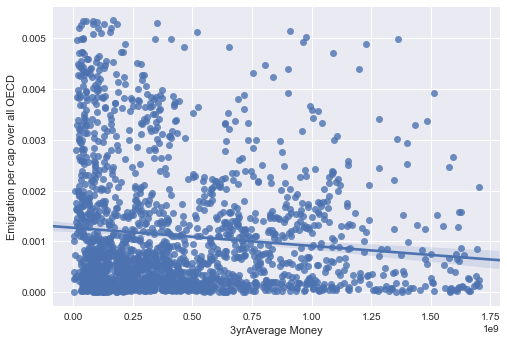

In [77]:
#and plot the regression
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=df.ix[:,2], y=df.ix[:,4], data=df)
plt.show()

In [78]:
#now we do the same stuff just not for the whole dataset but instead for only certain regions or continents
migVSmoney=pd.read_csv("FinalData/MigVsMoney_Cont_Reg31.csv")
migVSmoney.head()

,Recipient,Report Year,3yrAverage Money,3yrAverage Money per cap,Emigration per cap over all OECD,Emigration sum over all OECD countries,Continent,Region
0,Afghanistan,1996.0,8.471000e+07,18.218528,0.000716,12765.0,ASIA,SouthernAsia
1,Afghanistan,1997.0,1.530267e+08,15.158800,0.000715,13137.0,ASIA,SouthernAsia
2,Afghanistan,1998.0,2.553067e+08,14.351002,0.000645,12173.0,ASIA,SouthernAsia
3,Afghanistan,1999.0,2.446233e+08,13.321431,0.000613,11885.0,ASIA,SouthernAsia
4,Afghanistan,2000.0,2.410600e+08,12.825481,0.000824,16550.0,ASIA,SouthernAsia


In [79]:
uniquecontinents=migVSmoney.Continent.unique()
uniqueregions=migVSmoney.Region.unique()
uniquecountries=migVSmoney.Recipient.unique()

print(uniquecontinents)
print(uniqueregions)
print(len(uniquecountries))

['ASIA' 'EUROPE' 'AFRICA' 'AMERICA' 'CARRIBEANS' 'OCEANIA']
['SouthernAsia' 'SouthernEurope' 'NorthernAfrica' 'MiddleAfrica'
 'SouthernAmerica' 'WesternAsia' 'EasternEurope' 'CentralAmerica'
 'WesternAfrica' 'SouthernAfrica' 'EasternAfrica' 'SouthernEastAsia'
 'Carribeans' 'EasternAsia' 'Oceania' 'CentralAsia']
131


In [80]:
#load in the data
raw=migVSmoney
len(migVSmoney)
print(raw.head())

     Recipient  Report Year  3yrAverage Money  3yrAverage Money per cap  \
0  Afghanistan       1996.0      8.471000e+07                 18.218528   
1  Afghanistan       1997.0      1.530267e+08                 15.158800   
2  Afghanistan       1998.0      2.553067e+08                 14.351002   
3  Afghanistan       1999.0      2.446233e+08                 13.321431   
4  Afghanistan       2000.0      2.410600e+08                 12.825481   

   Emigration per cap over all OECD  Emigration sum over all OECD countries  \
0                          0.000716                                 12765.0   
1                          0.000715                                 13137.0   
2                          0.000645                                 12173.0   
3                          0.000613                                 11885.0   
4                          0.000824                                 16550.0   

  Continent        Region  
0      ASIA  SouthernAsia  
1      ASIA  South

SouthernAsia
159
87
shapiro: (0.8883140683174133, 1.777417992343544e-06)
shapiro: (0.7883371114730835, 7.554380454521947e-10)
LeveneResult(statistic=267.20029371596604, pvalue=7.5218753219889499e-37)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.135
Model:                                          OLS   Adj. R-squared:                  0.125
Method:                               Least Squares   F-statistic:                     13.29
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           0.000459
Time:                                      20:34:59   Log-Likelihood:                 520.19
No. Observations:                                87   AIC:                            -1036.
Df Residuals:                                    85   BIC:                            -1031.
Df Model:                                         1     

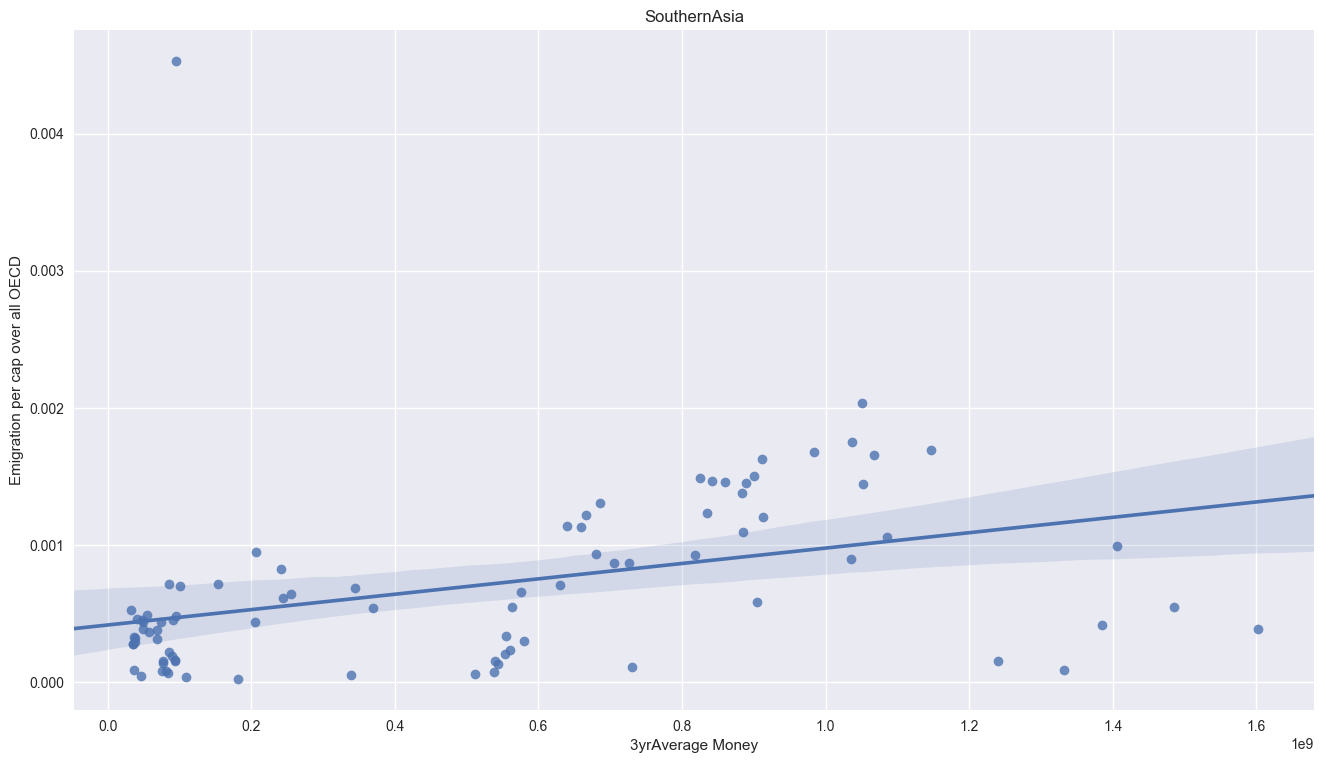

SouthernEurope
104
52
shapiro: (0.768291711807251, 1.1599163940445578e-07)
shapiro: (0.8567115068435669, 1.7039687008946203e-05)
LeveneResult(statistic=30.372826458550662, pvalue=2.6918005152311289e-07)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.051
Model:                                          OLS   Adj. R-squared:                  0.032
Method:                               Least Squares   F-statistic:                     2.679
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):              0.108
Time:                                      20:34:59   Log-Likelihood:                 262.74
No. Observations:                                52   AIC:                            -521.5
Df Residuals:                                    50   BIC:                            -517.6
Df Model:                                         1  

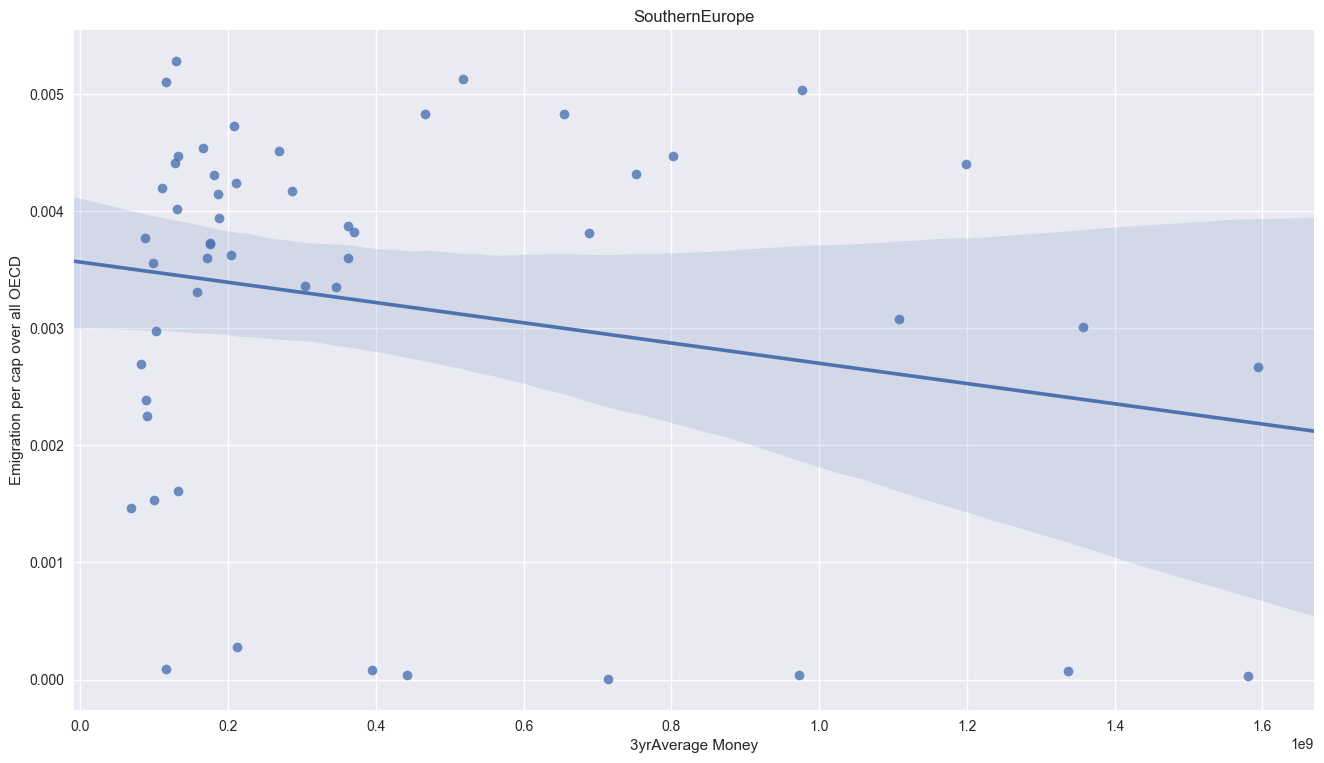

NorthernAfrica
113
89
shapiro: (0.913750410079956, 1.9488625184749253e-05)
shapiro: (0.8567649722099304, 8.406734508525915e-08)
LeveneResult(statistic=117.0952456321467, pvalue=3.0377392632141209e-21)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.202
Model:                                          OLS   Adj. R-squared:                  0.193
Method:                               Least Squares   F-statistic:                     21.98
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           1.01e-05
Time:                                      20:35:01   Log-Likelihood:                 475.68
No. Observations:                                89   AIC:                            -947.4
Df Residuals:                                    87   BIC:                            -942.4
Df Model:                                         1    

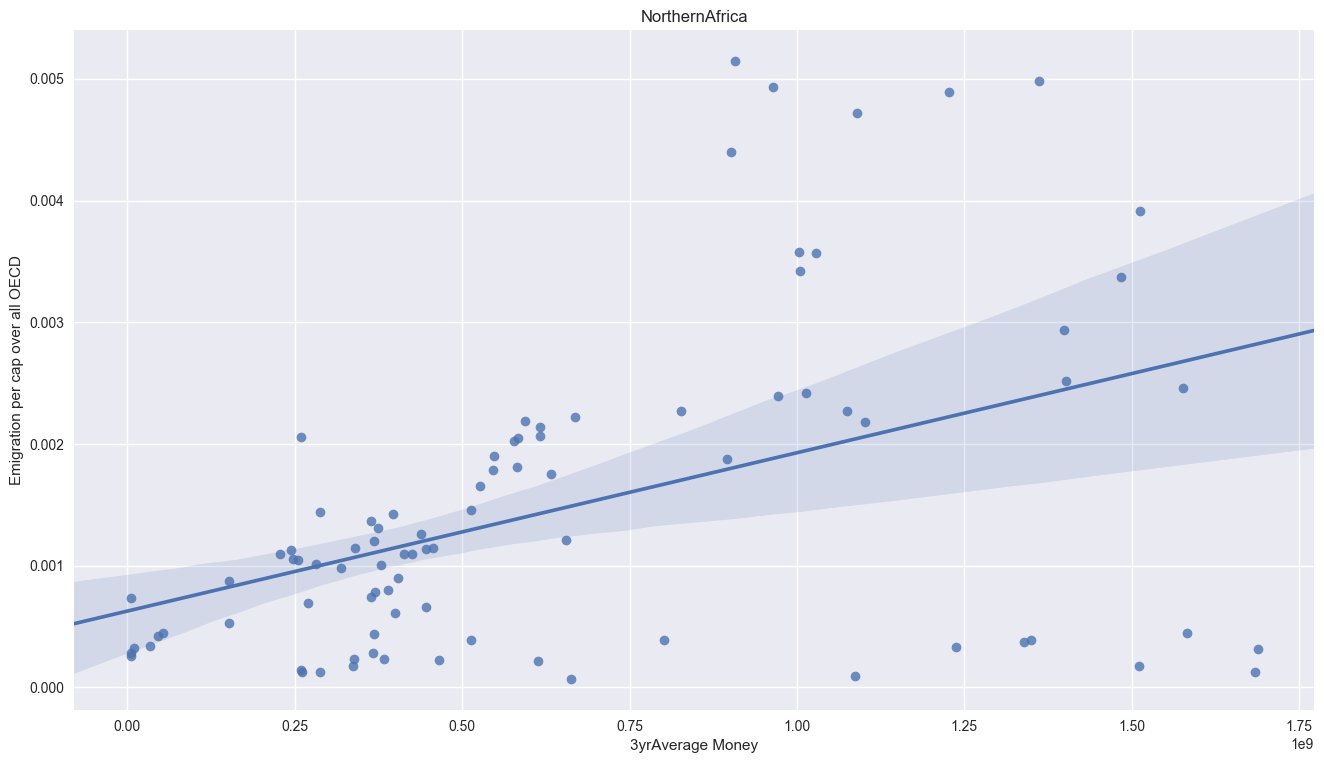

MiddleAfrica
180
156
shapiro: (0.8866657018661499, 1.4630022748818305e-09)
shapiro: (0.7032187581062317, 2.2823210119538517e-16)
LeveneResult(statistic=203.63152326672429, pvalue=7.3243989938377259e-36)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.115
Model:                                          OLS   Adj. R-squared:                  0.110
Method:                               Least Squares   F-statistic:                     20.07
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           1.45e-05
Time:                                      20:35:02   Log-Likelihood:                 863.24
No. Observations:                               156   AIC:                            -1722.
Df Residuals:                                   154   BIC:                            -1716.
Df Model:                                         1  

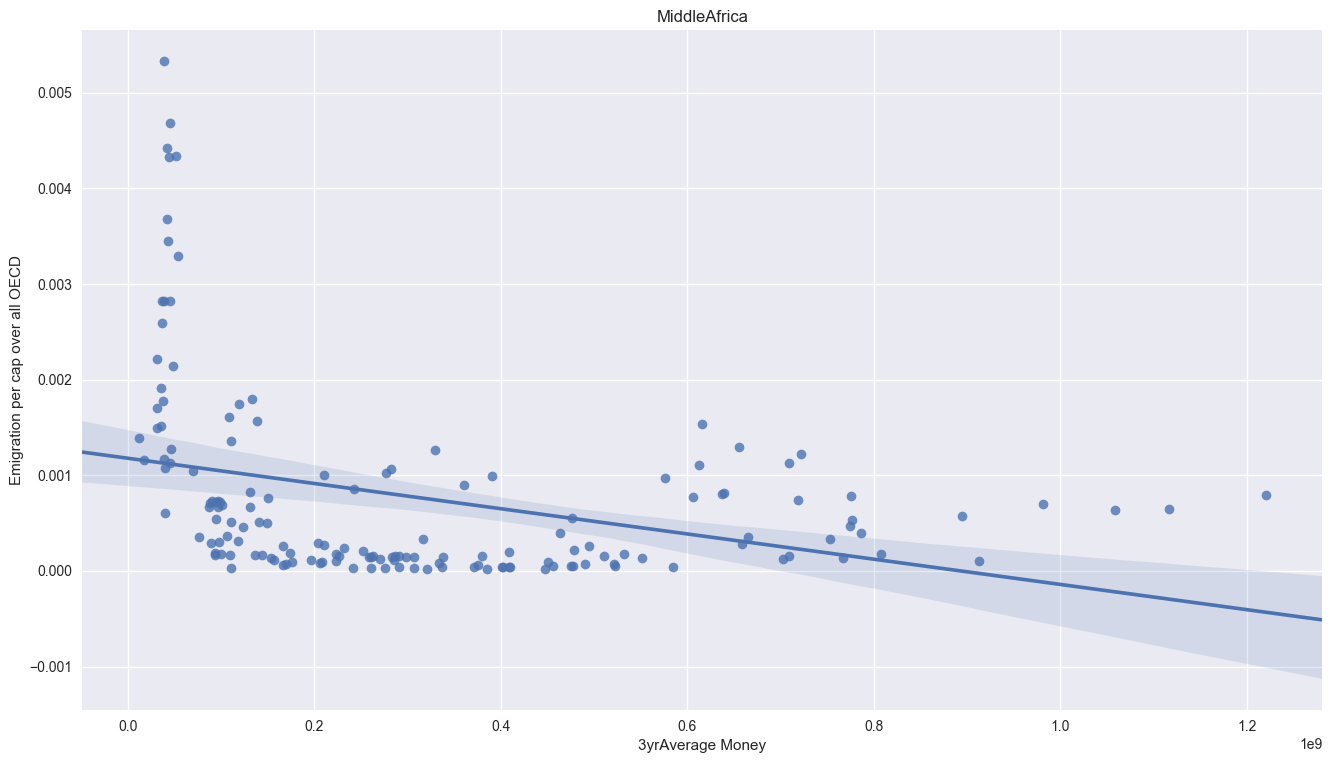

SouthernAmerica
200
164
shapiro: (0.887933611869812, 8.535062101522328e-10)
shapiro: (0.8888688683509827, 9.602246775486378e-10)
LeveneResult(statistic=233.59224697868217, pvalue=3.8393671008625977e-40)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.000
Model:                                          OLS   Adj. R-squared:                 -0.006
Method:                               Least Squares   F-statistic:                 0.0008046
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):              0.977
Time:                                      20:35:03   Log-Likelihood:                 874.06
No. Observations:                               164   AIC:                            -1744.
Df Residuals:                                   162   BIC:                            -1738.
Df Model:                                         1  

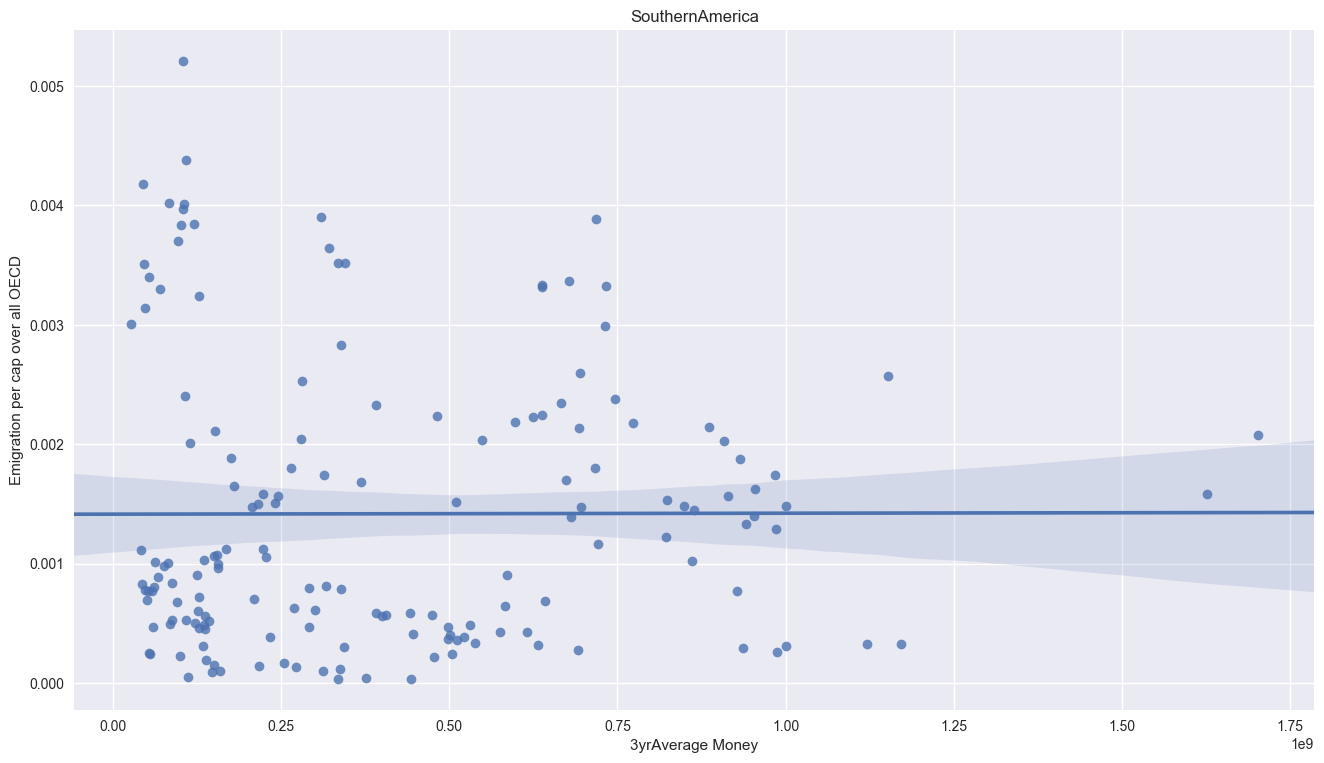

WesternAsia
180
163
shapiro: (0.8662586808204651, 7.17304965425214e-11)
shapiro: (0.9031990766525269, 6.887334258465216e-09)
LeveneResult(statistic=159.33465303320708, pvalue=5.5559652050236249e-30)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.000
Model:                                          OLS   Adj. R-squared:                 -0.006
Method:                               Least Squares   F-statistic:                  0.009165
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):              0.924
Time:                                      20:35:04   Log-Likelihood:                 874.85
No. Observations:                               163   AIC:                            -1746.
Df Residuals:                                   161   BIC:                            -1740.
Df Model:                                         1      

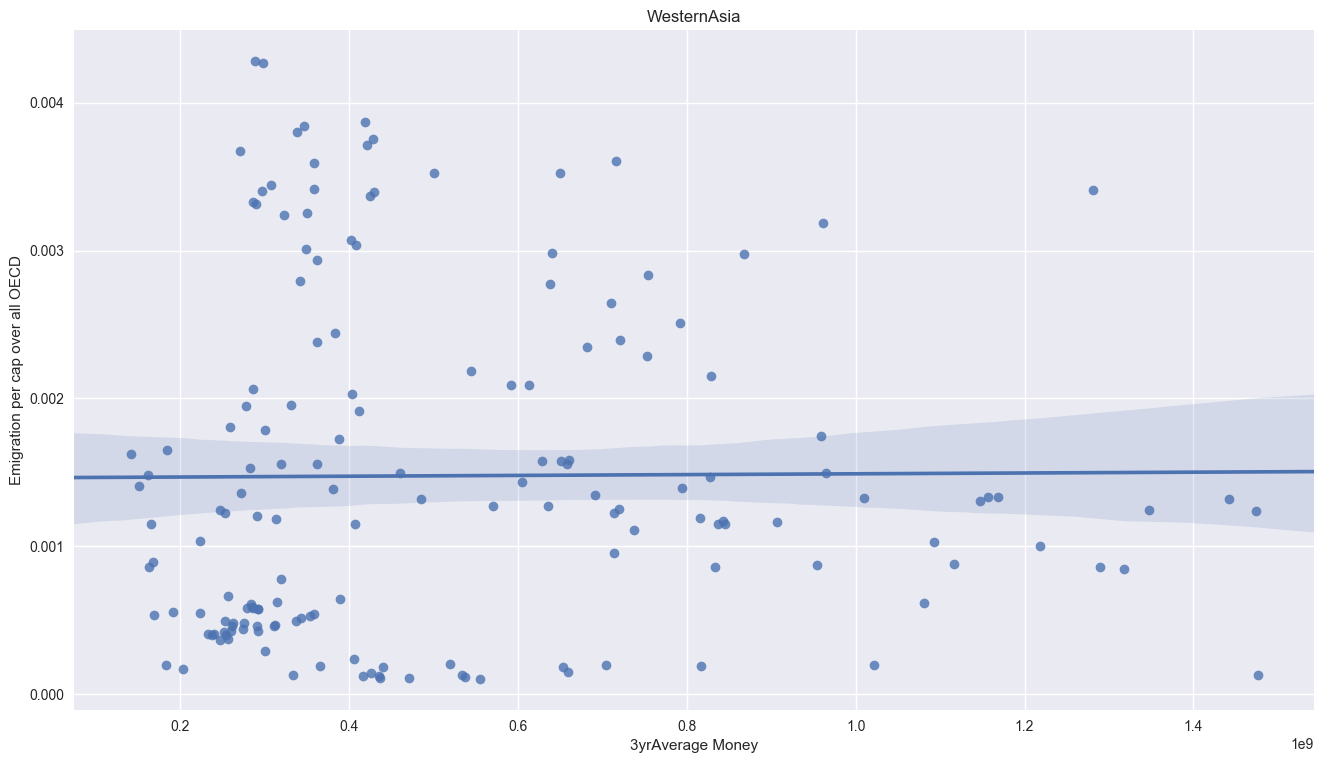

EasternEurope
32
25
shapiro: (0.8492046594619751, 0.0017011022428050637)
shapiro: (0.8480899930000305, 0.00162050302606076)
LeveneResult(statistic=49.611777063185684, pvalue=6.3053109686790318e-09)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.033
Model:                                          OLS   Adj. R-squared:                 -0.009
Method:                               Least Squares   F-statistic:                    0.7958
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):              0.382
Time:                                      20:35:05   Log-Likelihood:                 128.45
No. Observations:                                25   AIC:                            -252.9
Df Residuals:                                    23   BIC:                            -250.5
Df Model:                                         1       

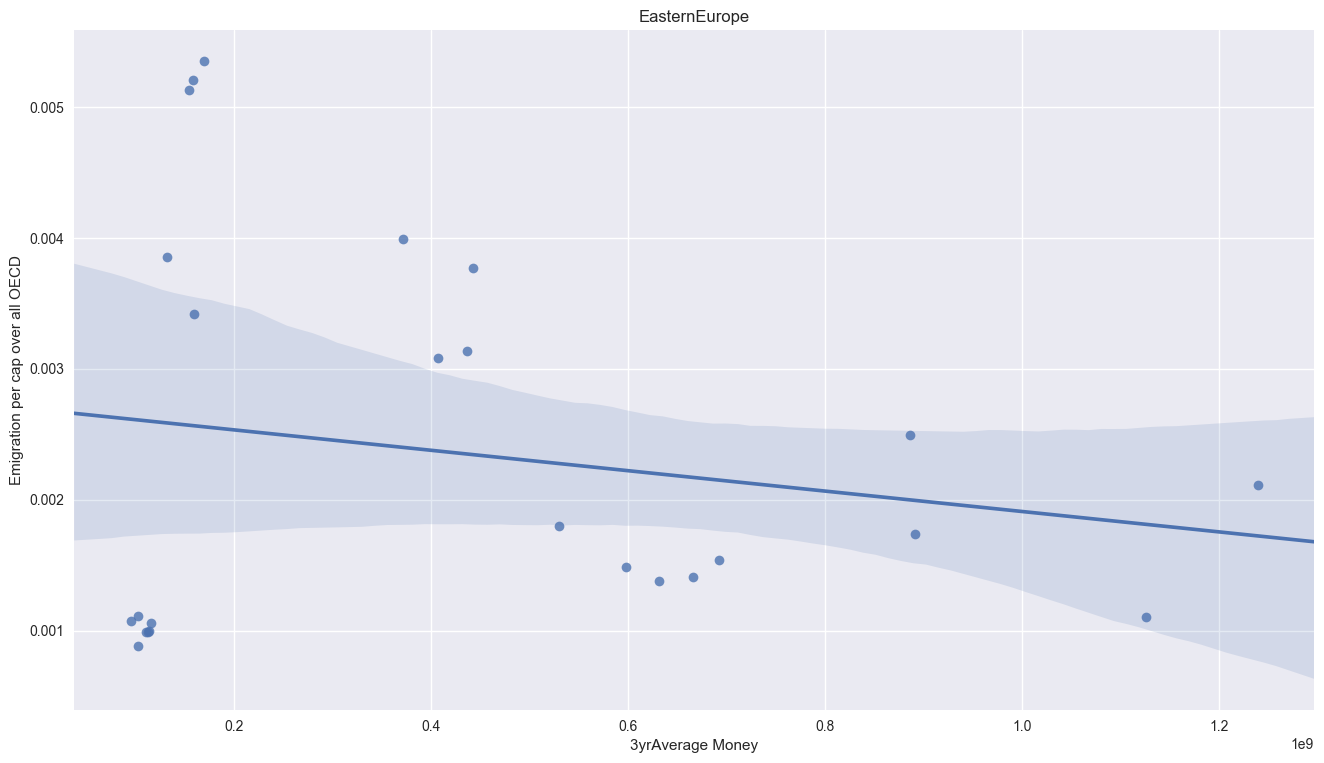

CentralAmerica
159
154
shapiro: (0.8395008444786072, 1.0676947173604567e-11)
shapiro: (0.8609985709190369, 9.451887189593222e-11)
LeveneResult(statistic=159.28027669966761, pvalue=1.1062938662466647e-29)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.002
Model:                                          OLS   Adj. R-squared:                 -0.005
Method:                               Least Squares   F-statistic:                    0.2767
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):              0.600
Time:                                      20:35:06   Log-Likelihood:                 822.22
No. Observations:                               154   AIC:                            -1640.
Df Residuals:                                   152   BIC:                            -1634.
Df Model:                                         1 

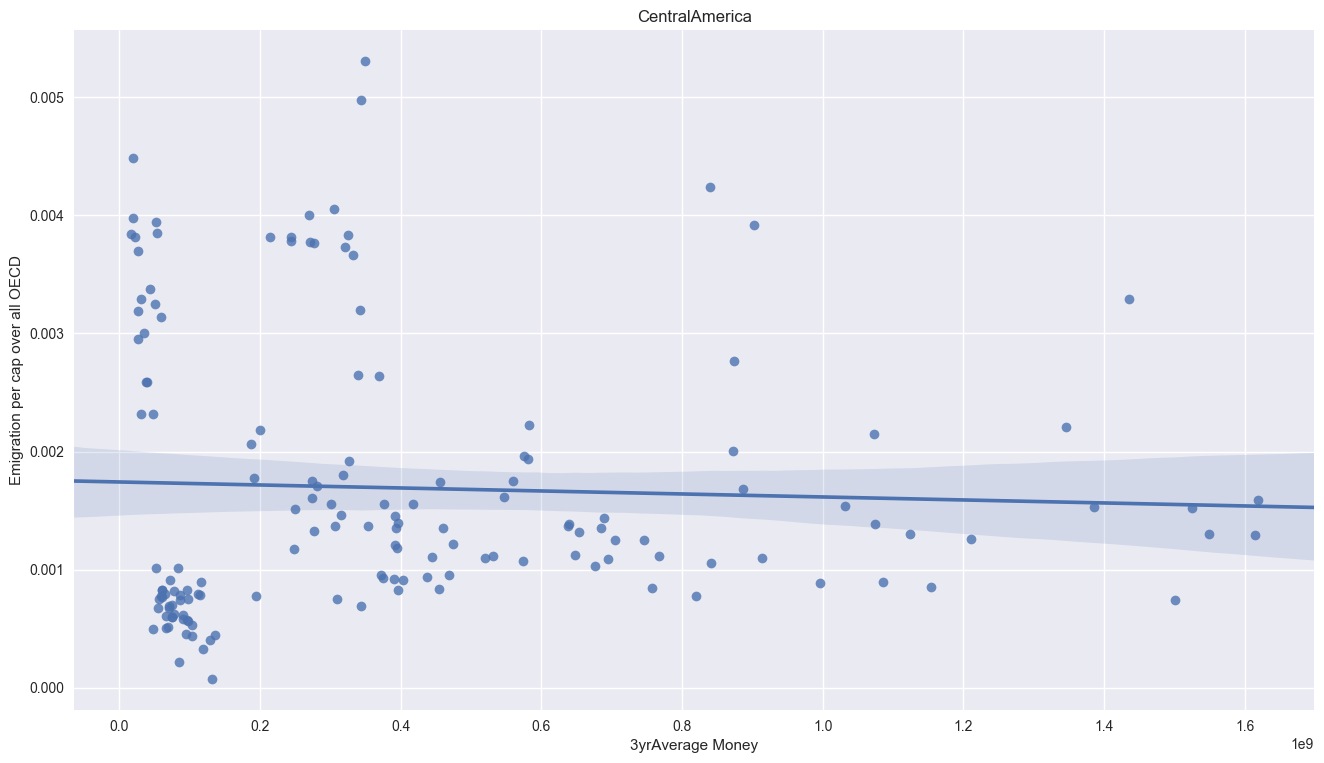

WesternAfrica
300
265
shapiro: (0.9022207260131836, 4.276224773586135e-12)
shapiro: (0.8190484046936035, 6.976625251240467e-17)
LeveneResult(statistic=327.95261510505935, pvalue=2.2701575082529477e-57)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.073
Model:                                          OLS   Adj. R-squared:                  0.070
Method:                               Least Squares   F-statistic:                     20.86
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           7.61e-06
Time:                                      20:35:07   Log-Likelihood:                 1557.0
No. Observations:                               265   AIC:                            -3110.
Df Residuals:                                   263   BIC:                            -3103.
Df Model:                                         1   

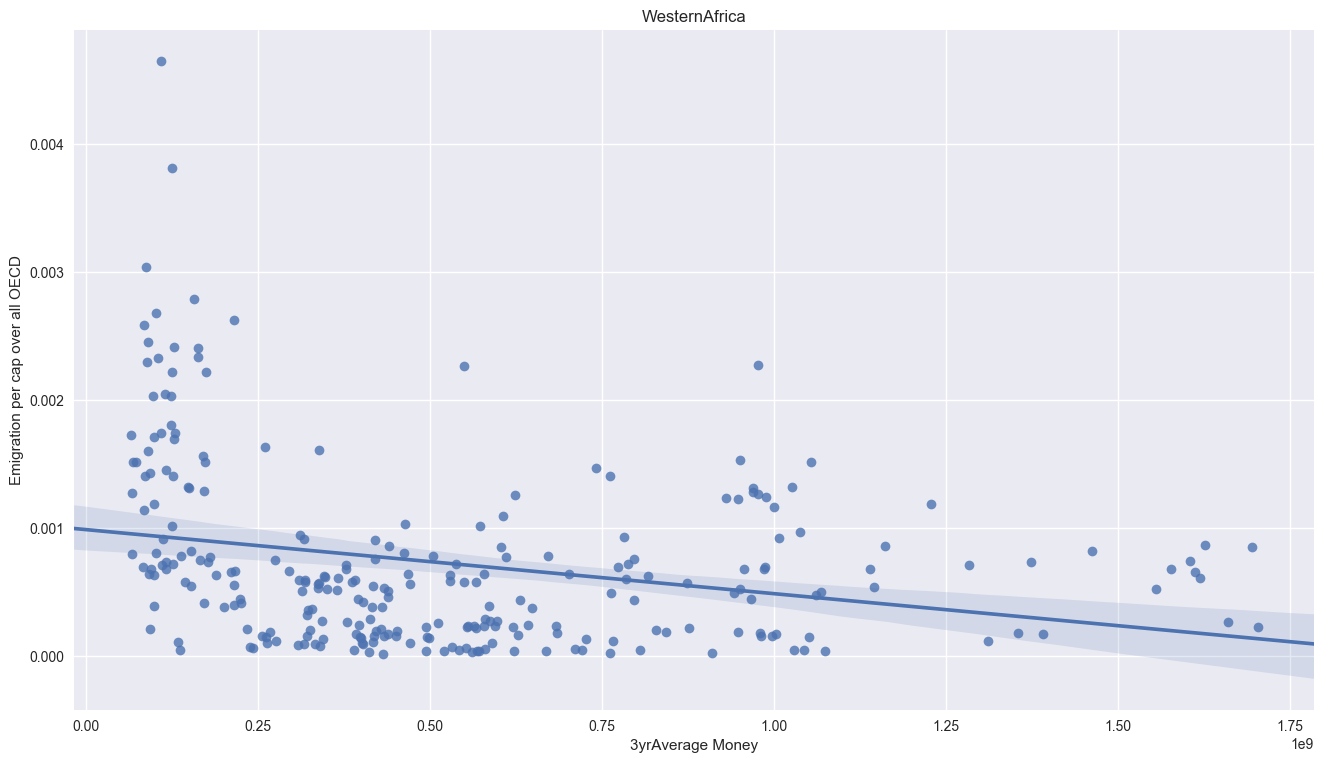

SouthernAfrica
99
99
shapiro: (0.7665690779685974, 3.0491852098801786e-11)
shapiro: (0.745634913444519, 8.383152678981265e-12)
LeveneResult(statistic=65.583322956890683, pvalue=5.816334163174108e-14)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.246
Model:                                          OLS   Adj. R-squared:                  0.238
Method:                               Least Squares   F-statistic:                     31.57
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           1.84e-07
Time:                                      20:35:08   Log-Likelihood:                 685.75
No. Observations:                                99   AIC:                            -1367.
Df Residuals:                                    97   BIC:                            -1362.
Df Model:                                         1     

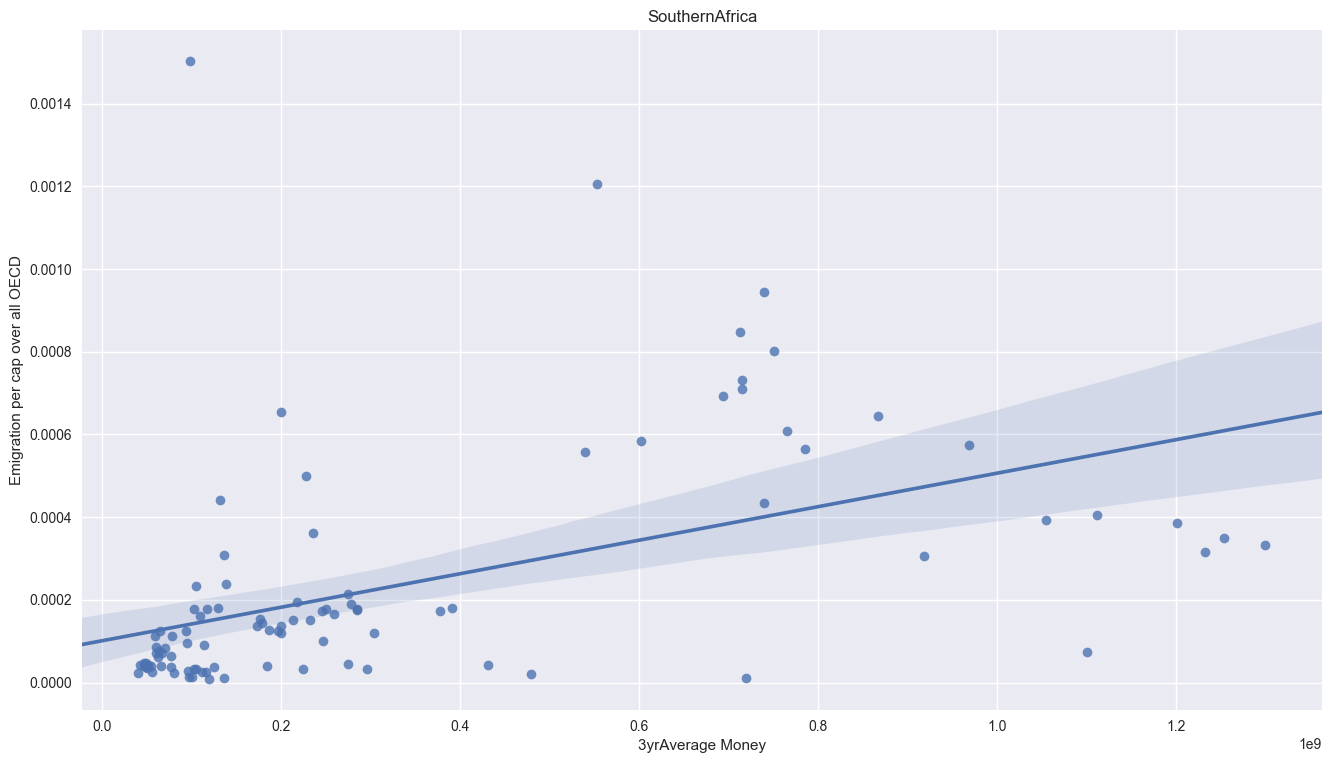

EasternAfrica
339
280
shapiro: (0.9103779792785645, 7.031940568030803e-12)
shapiro: (0.6959125399589539, 3.4392464920657655e-22)
LeveneResult(statistic=557.05835298959926, pvalue=6.2124917099000729e-86)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.286
Model:                                          OLS   Adj. R-squared:                  0.283
Method:                               Least Squares   F-statistic:                     111.2
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           4.34e-22
Time:                                      20:35:09   Log-Likelihood:                 1561.0
No. Observations:                               280   AIC:                            -3118.
Df Residuals:                                   278   BIC:                            -3111.
Df Model:                                         1  

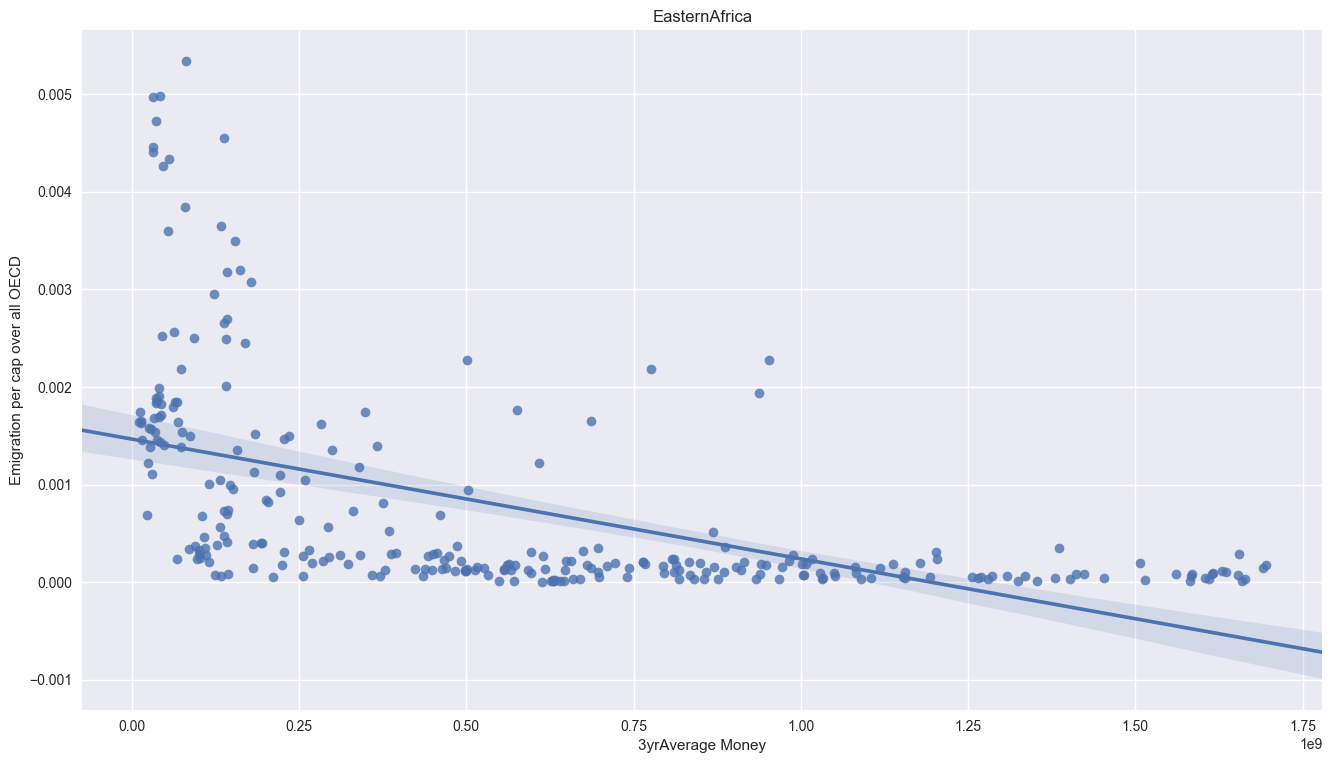

SouthernEastAsia
178
141
shapiro: (0.9043987989425659, 5.0699636489071054e-08)
shapiro: (0.8416446447372437, 5.0793456246589486e-11)
LeveneResult(statistic=163.15859148976762, pvalue=9.4663778715963711e-30)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.380
Model:                                          OLS   Adj. R-squared:                  0.376
Method:                               Least Squares   F-statistic:                     85.18
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           4.05e-16
Time:                                      20:35:10   Log-Likelihood:                 887.37
No. Observations:                               141   AIC:                            -1771.
Df Residuals:                                   139   BIC:                            -1765.
Df Model:                                        

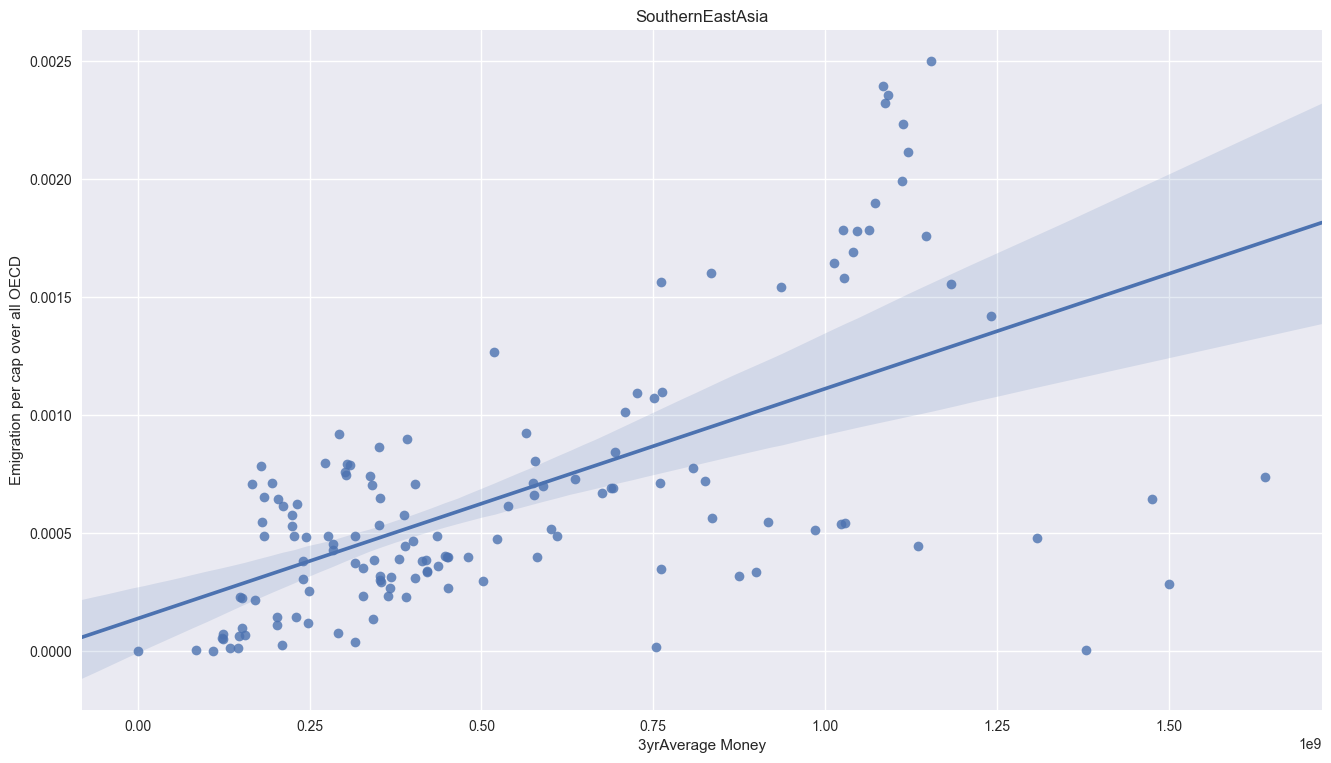

Carribeans
158
59
shapiro: (0.7376980781555176, 6.233082494588871e-09)
shapiro: (0.974037766456604, 0.2379850447177887)
LeveneResult(statistic=30.069301283687341, pvalue=2.4713263520534513e-07)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.088
Model:                                          OLS   Adj. R-squared:                  0.072
Method:                               Least Squares   F-statistic:                     5.531
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):             0.0222
Time:                                      20:35:11   Log-Likelihood:                 323.23
No. Observations:                                59   AIC:                            -642.5
Df Residuals:                                    57   BIC:                            -638.3
Df Model:                                         1           

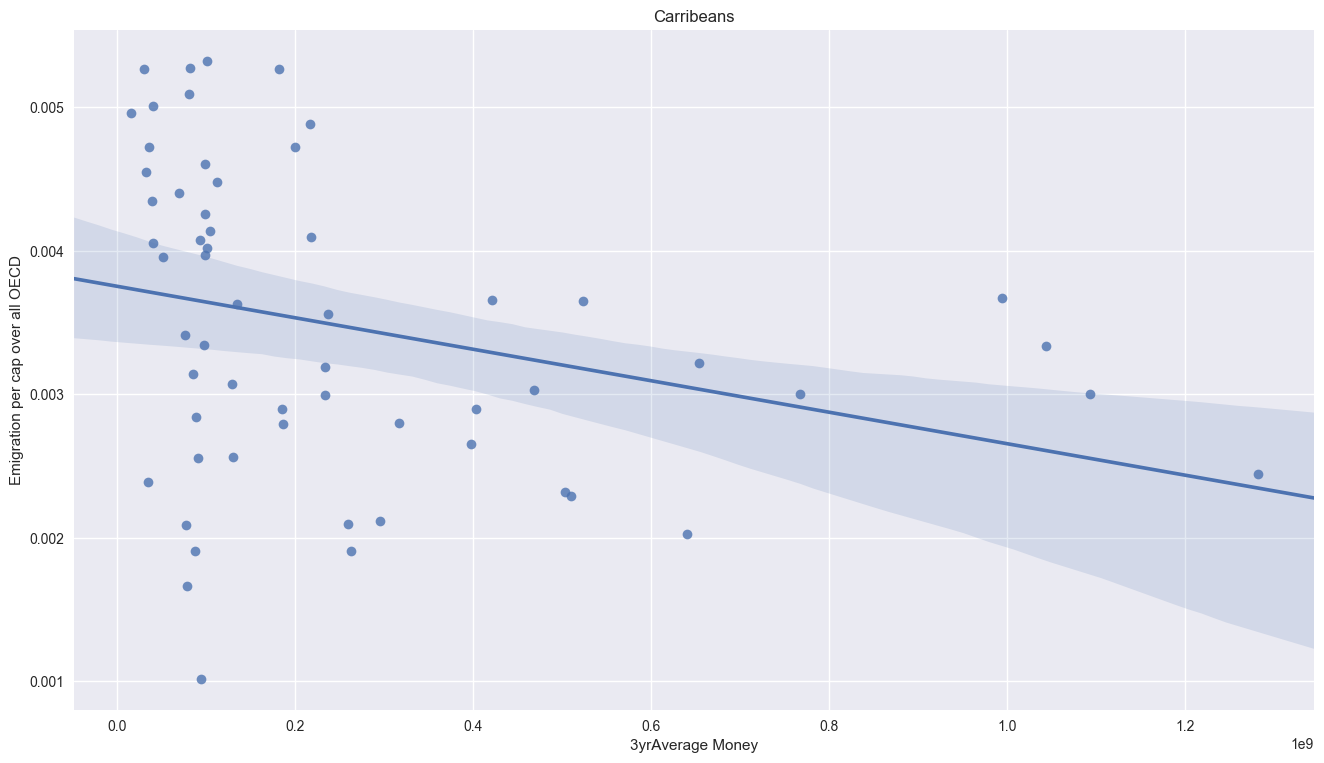

EasternAsia
40
37
shapiro: (0.9583520293235779, 0.17906570434570312)
shapiro: (0.7474515438079834, 1.3395841733654379e-06)
LeveneResult(statistic=67.194021750911602, pvalue=6.568376058899583e-12)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.575
Model:                                          OLS   Adj. R-squared:                  0.563
Method:                               Least Squares   F-statistic:                     47.33
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           5.46e-08
Time:                                      20:35:12   Log-Likelihood:                 201.78
No. Observations:                                37   AIC:                            -399.6
Df Residuals:                                    35   BIC:                            -396.3
Df Model:                                         1         

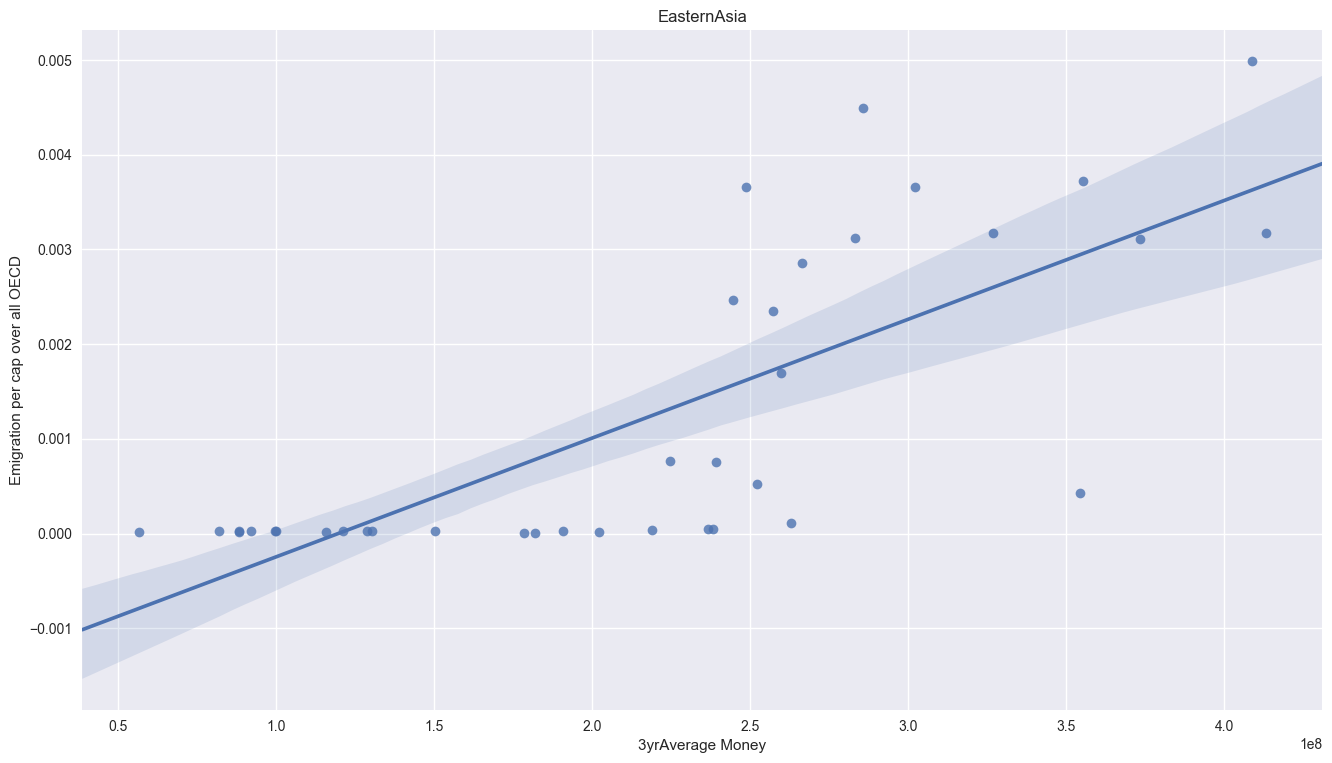

Oceania
208
134
shapiro: (0.765738308429718, 2.3816197495044045e-13)
shapiro: (0.7532660961151123, 1.0000586648942558e-13)
LeveneResult(statistic=78.372867912455604, pvalue=1.2291242449869918e-16)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.213
Model:                                          OLS   Adj. R-squared:                  0.207
Method:                               Least Squares   F-statistic:                     35.67
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           2.04e-08
Time:                                      20:35:13   Log-Likelihood:                 703.03
No. Observations:                               134   AIC:                            -1402.
Df Residuals:                                   132   BIC:                            -1396.
Df Model:                                         1        

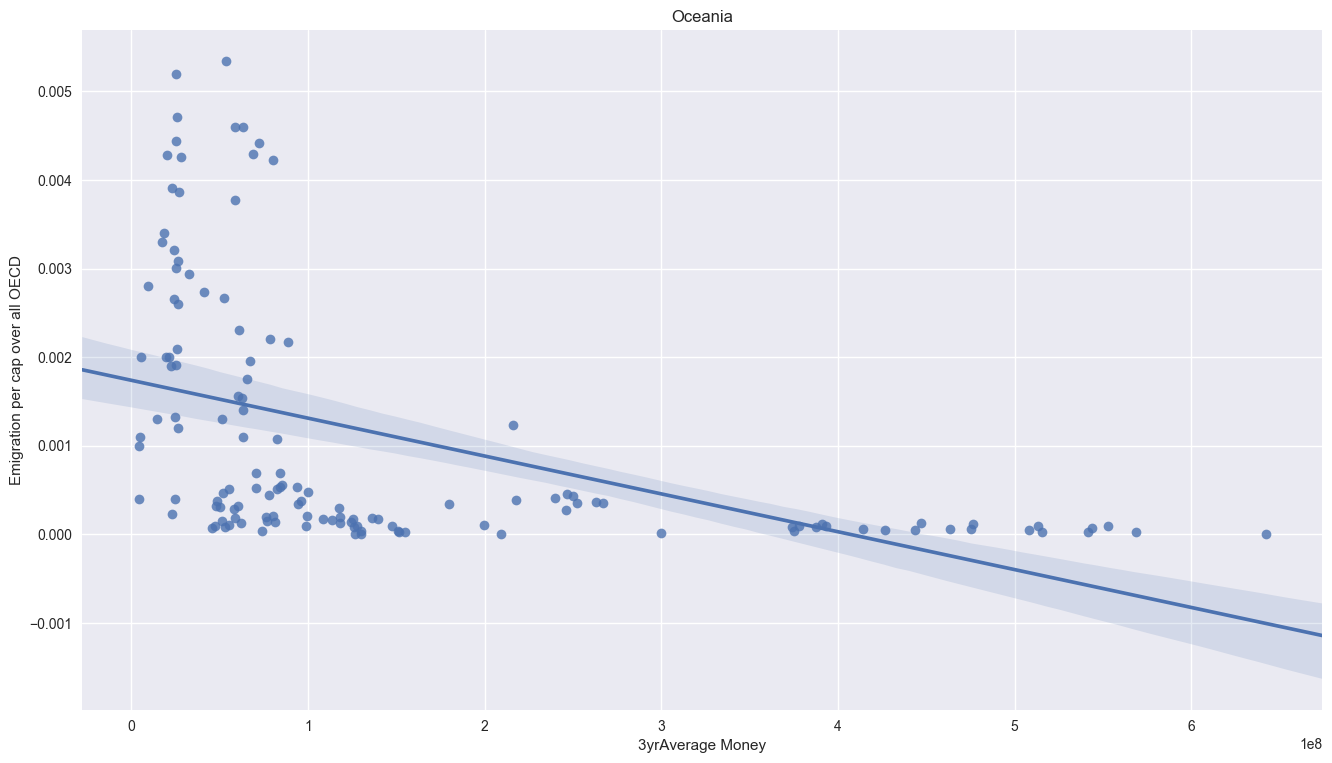

CentralAsia
100
97
shapiro: (0.6799088716506958, 3.110964177238662e-13)
shapiro: (0.9185749292373657, 1.5648391126887873e-05)
LeveneResult(statistic=42.976979663172756, pvalue=4.9844706962547035e-10)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.034
Model:                                          OLS   Adj. R-squared:                  0.024
Method:                               Least Squares   F-statistic:                     3.375
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):             0.0693
Time:                                      20:35:14   Log-Likelihood:                 661.41
No. Observations:                                97   AIC:                            -1319.
Df Residuals:                                    95   BIC:                            -1314.
Df Model:                                         1     

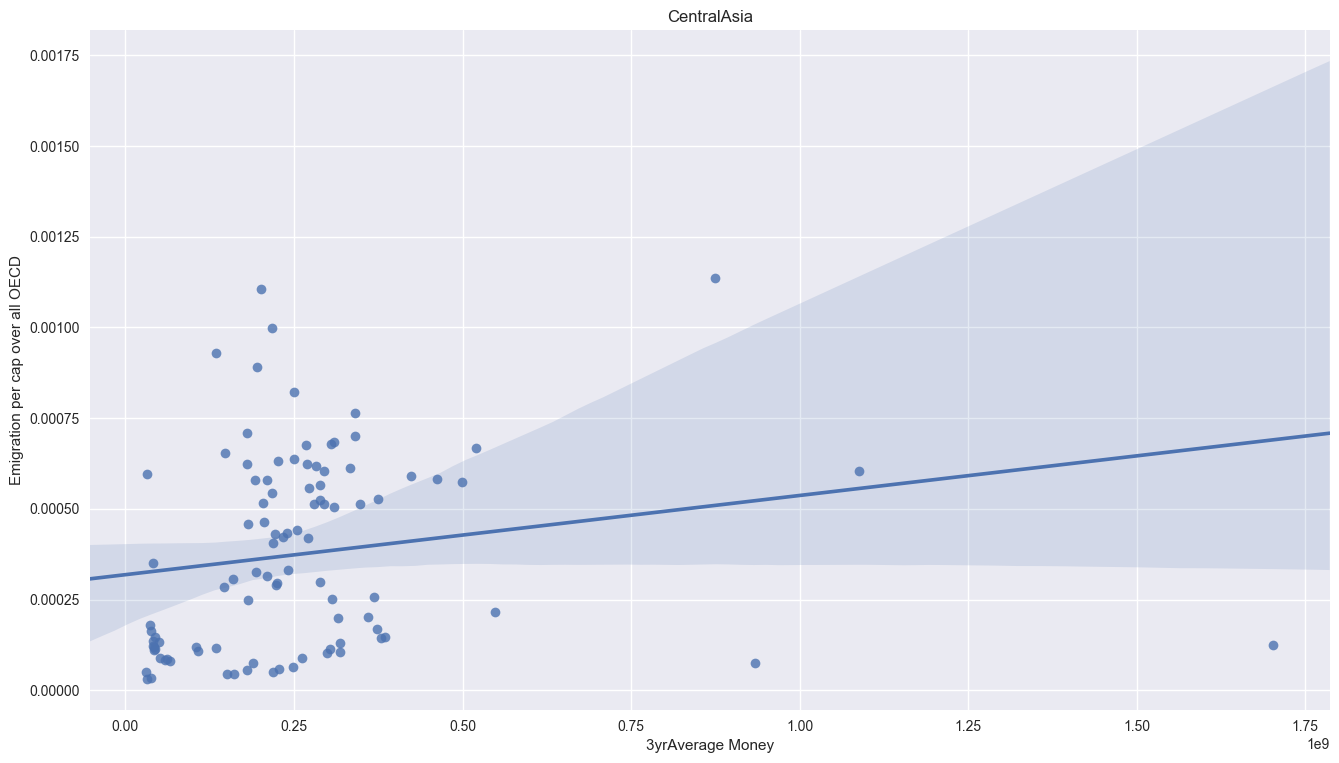

In [81]:
#now we run a for-loop for the entire analysis that we did so far and iterate through regions
for i in uniqueregions:
    fig = plt.figure(figsize=(16, 9), dpi=100)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    region=i
    print(region)
    df=raw[raw["Region"]==region]
    print(len(df))
    migVSmoneyQ=df.quantile([.25, 0.])
    MigrationUPboundary=migVSmoneyQ.iloc[1][-2]
    MigrationLOWboundary=migVSmoneyQ.iloc[0][-2]
    MoneyUPboundary=migVSmoneyQ.iloc[1][1]
    MoneyLOWboundary=migVSmoneyQ.iloc[0][1]
    
    IQRmoneyX=(preMoneyUPboundary-preMoneyLOWboundary)*1.5
    IQRmigX=(preMigrationUPboundary-preMigrationLOWboundary)*1.5
    MoneyUPboundary=preMoneyUPboundary+IQRmoneyX
    MoneyLOWboundary=preMoneyLOWboundary-IQRmoneyX
    MigrationLOWboundary=preMigrationLOWboundary-IQRmigX
    MigrationUPboundary=preMigrationUPboundary+IQRmigX
    
    df = df[(df.ix[:,2] > MoneyLOWboundary) & (df.ix[:,2] < MoneyUPboundary) ]
    df = df[(df.ix[:,4] > MigrationLOWboundary) & (df.ix[:,4] < MigrationUPboundary)]
    print(len(df))

    x = df.ix[:,2]
    y = df.ix[:,4]

    shapiro_results = scipy.stats.shapiro(x)

    print("shapiro:",shapiro_results)
    shapiro_results = scipy.stats.shapiro(y)
    print("shapiro:",shapiro_results)

    x = df.ix[:,2]
    y = df.ix[:,4]

    levene_results = scipy.stats.levene(x,y)

    print(levene_results)
    X = df.ix[:,2]
    Y = df.ix[:,4]

    X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

    # Note the difference in argument order
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) # make the predictions by the model

    # Print out the statistics
    print(model.summary())
    sns.regplot(x=df.ix[:,2], y=df.ix[:,4], data=df)
    plt.title(region)
    plt.savefig(region+'.pdf', transparent = True)

    plt.show()

ASIA
657
657
shapiro: (0.5950258374214172, 1.8168454748619625e-36)
shapiro: (0.4485323429107666, 1.035293318427818e-40)
LeveneResult(statistic=207.44570675604837, pvalue=8.960422198792896e-44)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.001
Model:                                          OLS   Adj. R-squared:                 -0.001
Method:                               Least Squares   F-statistic:                    0.3580
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):              0.550
Time:                                      20:35:15   Log-Likelihood:                 3211.9
No. Observations:                               657   AIC:                            -6420.
Df Residuals:                                   655   BIC:                            -6411.
Df Model:                                         1            

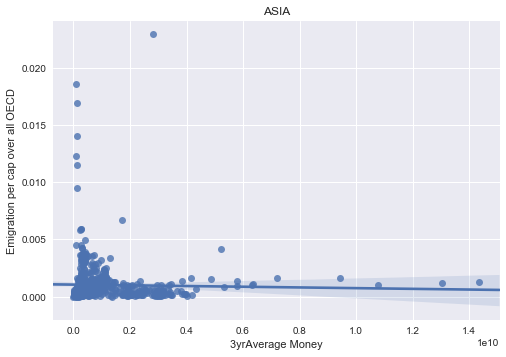

EUROPE
136
136
shapiro: (0.7724993228912354, 3.0113693656741436e-13)
shapiro: (0.8011602163314819, 2.6693059654997464e-12)
LeveneResult(statistic=89.842416276445178, pvalue=1.3849633030726822e-18)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.020
Model:                                          OLS   Adj. R-squared:                  0.012
Method:                               Least Squares   F-statistic:                     2.692
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):              0.103
Time:                                      20:35:15   Log-Likelihood:                 512.51
No. Observations:                               136   AIC:                            -1021.
Df Residuals:                                   134   BIC:                            -1015.
Df Model:                                         1        

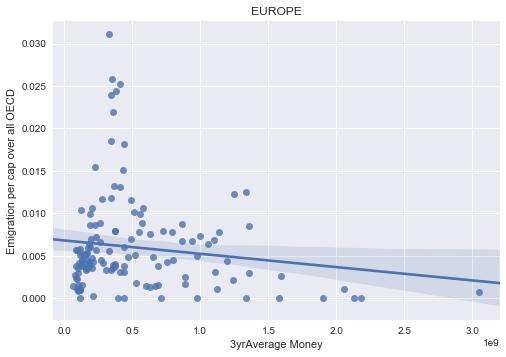

AFRICA
1031
1031
shapiro: (0.7458714246749878, 5.109116712723448e-37)
shapiro: (0.44747650623321533, 0.0)
LeveneResult(statistic=596.73587357761437, pvalue=5.9281387117665377e-116)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.037
Model:                                          OLS   Adj. R-squared:                  0.036
Method:                               Least Squares   F-statistic:                     39.91
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           3.95e-10
Time:                                      20:35:16   Log-Likelihood:                 4862.3
No. Observations:                              1031   AIC:                            -9721.
Df Residuals:                                  1029   BIC:                            -9711.
Df Model:                                         1                        

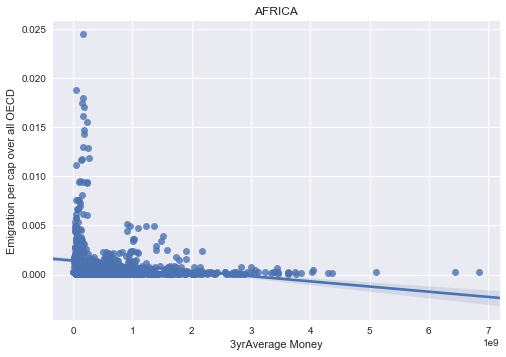

AMERICA
359
359
shapiro: (0.8121046423912048, 4.000230902022237e-20)
shapiro: (0.7094299793243408, 1.7385606882552727e-24)
LeveneResult(statistic=294.62838330270364, pvalue=1.4310037769820687e-55)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.008
Model:                                          OLS   Adj. R-squared:                  0.005
Method:                               Least Squares   F-statistic:                     2.799
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):             0.0952
Time:                                      20:35:16   Log-Likelihood:                 1613.0
No. Observations:                               359   AIC:                            -3222.
Df Residuals:                                   357   BIC:                            -3214.
Df Model:                                         1        

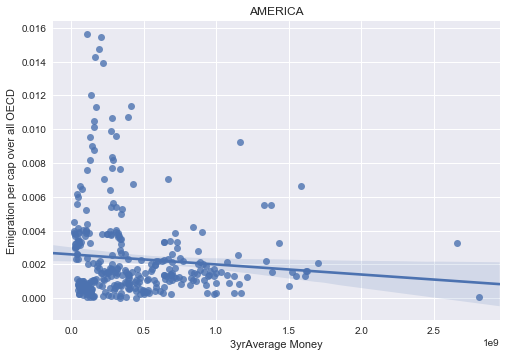

CARRIBEANS
158
158
shapiro: (0.5118632316589355, 8.163653068232535e-21)
shapiro: (0.9701117277145386, 0.0016698222607374191)
LeveneResult(statistic=38.41392457879553, pvalue=1.7965760774773271e-09)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.135
Model:                                          OLS   Adj. R-squared:                  0.129
Method:                               Least Squares   F-statistic:                     24.32
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           2.07e-06
Time:                                      20:35:16   Log-Likelihood:                 703.26
No. Observations:                               158   AIC:                            -1403.
Df Residuals:                                   156   BIC:                            -1396.
Df Model:                                         1       

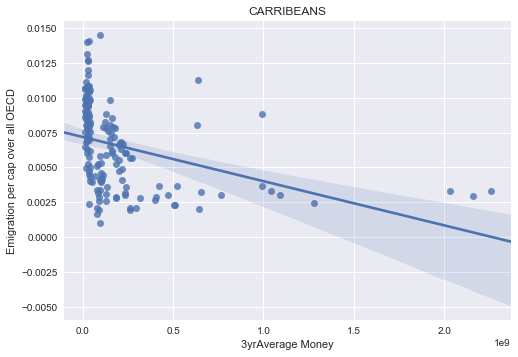

OCEANIA
208
208
shapiro: (0.4703436493873596, 1.612288216194611e-24)
shapiro: (0.8106979727745056, 3.60738076169982e-15)
LeveneResult(statistic=39.83424977301592, pvalue=7.1217622145234865e-10)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.036
Model:                                          OLS   Adj. R-squared:                  0.031
Method:                               Least Squares   F-statistic:                     7.719
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):            0.00597
Time:                                      20:35:17   Log-Likelihood:                 787.22
No. Observations:                               208   AIC:                            -1570.
Df Residuals:                                   206   BIC:                            -1564.
Df Model:                                         1           

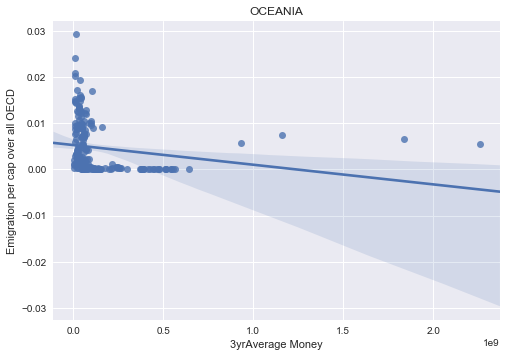

In [82]:
#now we run a for-loop for the entire analysis that we did so far and iterate through continents
for i in uniquecontinents:
    continent=i
    print(continent)
    df=raw[raw["Continent"]==continent]
    print(len(df))
    migVSmoneyQ=df.quantile([.25, 0.75])
    MigrationUPboundary=migVSmoneyQ.iloc[1][-2]
    MigrationLOWboundary=migVSmoneyQ.iloc[0][-2]
    MoneyUPboundary=migVSmoneyQ.iloc[1][1]
    MoneyLOWboundary=migVSmoneyQ.iloc[0][1]
    
    IQRmoneyX=(preMoneyUPboundary-preMoneyLOWboundary)*1.5
    IQRmigX=(preMigrationUPboundary-preMigrationLOWboundary)*1.5
    MoneyUPboundary=preMoneyUPboundary+IQRmoneyX
    MoneyLOWboundary=preMoneyLOWboundary-IQRmoneyX
    MigrationLOWboundary=preMigrationLOWboundary-IQRmigX
    MigrationUPboundary=preMigrationUPboundary+IQRmigX
    
    print(len(df))

    x = df.ix[:,2]
    y = df.ix[:,4]

    shapiro_results = scipy.stats.shapiro(x)

    print("shapiro:",shapiro_results)
    shapiro_results = scipy.stats.shapiro(y)
    print("shapiro:",shapiro_results)

    x = df.ix[:,2]
    y = df.ix[:,4]

    levene_results = scipy.stats.levene(x,y)

    print(levene_results)
    X = df.ix[:,2]
    Y = df.ix[:,4]

    X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

    # Note the difference in argument order
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) # make the predictions by the model

    # Print out the statistics
    print(model.summary())
    sns.regplot(x=df.ix[:,2], y=df.ix[:,4], data=df)
    plt.title(continent)

    plt.show()

300
265
shapiro: (0.9022207260131836, 4.276224773586135e-12)
shapiro: (0.8190484046936035, 6.976625251240467e-17)
LeveneResult(statistic=327.95261510505935, pvalue=2.2701575082529477e-57)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.073
Model:                                          OLS   Adj. R-squared:                  0.070
Method:                               Least Squares   F-statistic:                     20.86
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           7.61e-06
Time:                                      20:35:17   Log-Likelihood:                 1557.0
No. Observations:                               265   AIC:                            -3110.
Df Residuals:                                   263   BIC:                            -3103.
Df Model:                                         1                 

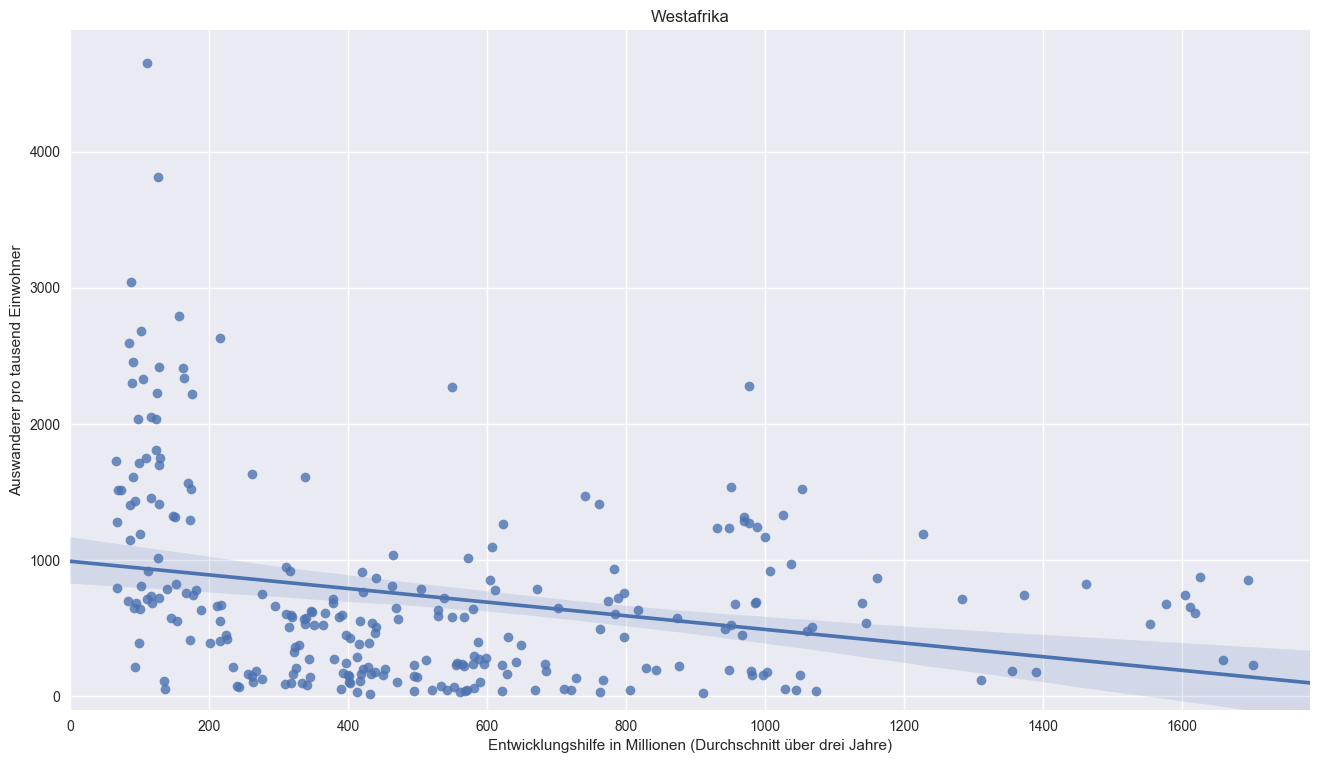

In [83]:
#Now we optimise the chart with the right description of the axes etc. for the case of WesternAfrica
fig = plt.figure(figsize=(16, 9), dpi=100)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
region="WesternAfrica"
df=raw[raw["Region"]==region]
print(len(df))
migVSmoneyQ=df.quantile([.25, 0.])
MigrationUPboundary=migVSmoneyQ.iloc[1][-2]
MigrationLOWboundary=migVSmoneyQ.iloc[0][-2]
MoneyUPboundary=migVSmoneyQ.iloc[1][1]
MoneyLOWboundary=migVSmoneyQ.iloc[0][1]

IQRmoneyX=(preMoneyUPboundary-preMoneyLOWboundary)*1.5
IQRmigX=(preMigrationUPboundary-preMigrationLOWboundary)*1.5
MoneyUPboundary=preMoneyUPboundary+IQRmoneyX
MoneyLOWboundary=preMoneyLOWboundary-IQRmoneyX
MigrationLOWboundary=preMigrationLOWboundary-IQRmigX
MigrationUPboundary=preMigrationUPboundary+IQRmigX

df = df[(df.ix[:,2] > MoneyLOWboundary) & (df.ix[:,2] < MoneyUPboundary) ]
df = df[(df.ix[:,4] > MigrationLOWboundary) & (df.ix[:,4] < MigrationUPboundary)]
print(len(df))

x = df.ix[:,2]
y = df.ix[:,4]

shapiro_results = scipy.stats.shapiro(x)

print("shapiro:",shapiro_results)
shapiro_results = scipy.stats.shapiro(y)
print("shapiro:",shapiro_results)

x = df.ix[:,2]
y = df.ix[:,4]

levene_results = scipy.stats.levene(x,y)

print(levene_results)
X = df.ix[:,2]
Y = df.ix[:,4]

X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())
#adjusted the metrics to per million or in million
sns.regplot(x=df.ix[:,2]/1000000, y=df.ix[:,4]*1000000, data=df)
plt.ylim(-100,)
plt.xlim(0,)
plt.title("Westafrika")
plt.xlabel('Entwicklungshilfe in Millionen (Durchschnitt über drei Jahre)')
plt.ylabel('Auswanderer pro tausend Einwohner')
plt.savefig(region+'.pdf', transparent = True)

plt.show()

339
280
shapiro: (0.9103779792785645, 7.031940568030803e-12)
shapiro: (0.6959125399589539, 3.4392464920657655e-22)
LeveneResult(statistic=557.05835298959926, pvalue=6.2124917099000729e-86)
                                   OLS Regression Results                                   
Dep. Variable:     Emigration per cap over all OECD   R-squared:                       0.286
Model:                                          OLS   Adj. R-squared:                  0.283
Method:                               Least Squares   F-statistic:                     111.2
Date:                              Sun, 26 Nov 2017   Prob (F-statistic):           4.34e-22
Time:                                      20:35:18   Log-Likelihood:                 1561.0
No. Observations:                               280   AIC:                            -3118.
Df Residuals:                                   278   BIC:                            -3111.
Df Model:                                         1                

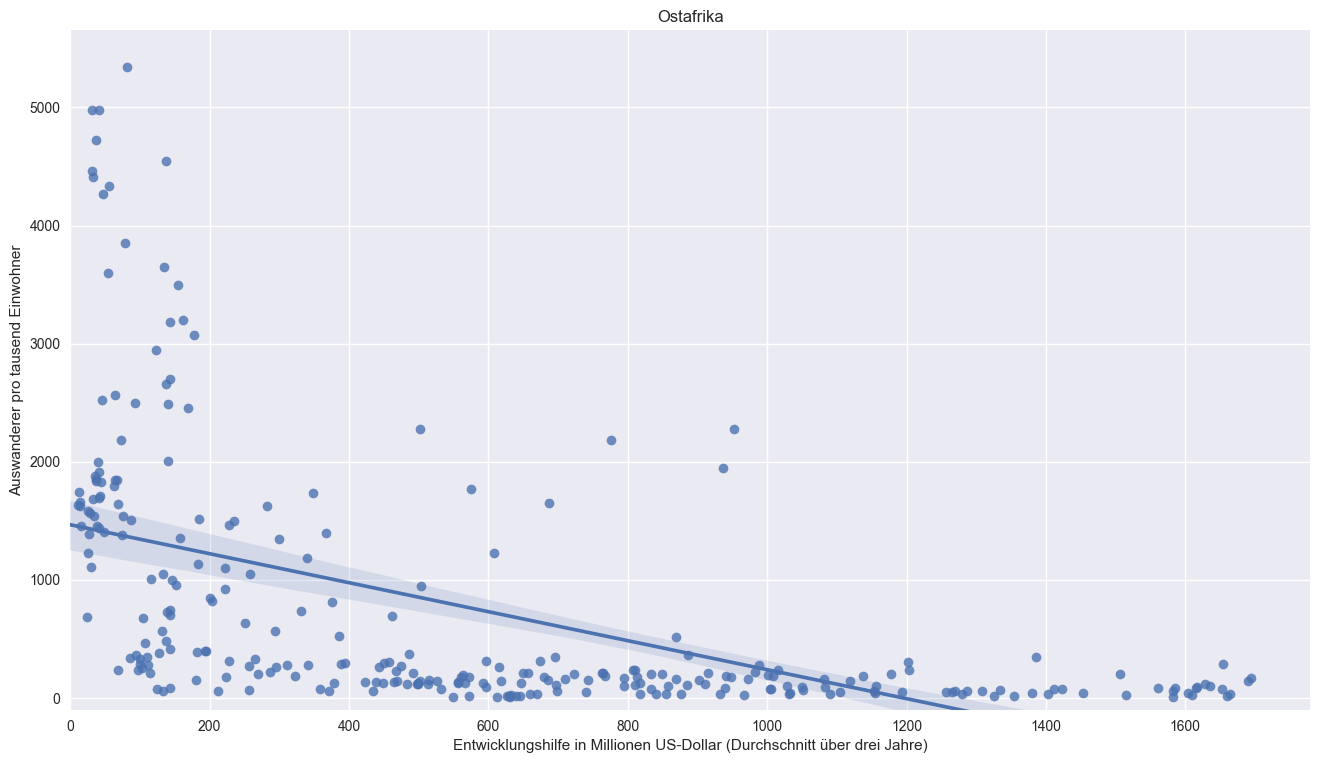

In [84]:
#And for EasternAfrica
fig = plt.figure(figsize=(16, 9), dpi=100)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
region="EasternAfrica"
df=raw[raw["Region"]==region]
print(len(df))
migVSmoneyQ=df.quantile([.25, 0.])
MigrationUPboundary=migVSmoneyQ.iloc[1][-2]
MigrationLOWboundary=migVSmoneyQ.iloc[0][-2]
MoneyUPboundary=migVSmoneyQ.iloc[1][1]
MoneyLOWboundary=migVSmoneyQ.iloc[0][1]

IQRmoneyX=(preMoneyUPboundary-preMoneyLOWboundary)*1.5
IQRmigX=(preMigrationUPboundary-preMigrationLOWboundary)*1.5
MoneyUPboundary=preMoneyUPboundary+IQRmoneyX
MoneyLOWboundary=preMoneyLOWboundary-IQRmoneyX
MigrationLOWboundary=preMigrationLOWboundary-IQRmigX
MigrationUPboundary=preMigrationUPboundary+IQRmigX

df = df[(df.ix[:,2] > MoneyLOWboundary) & (df.ix[:,2] < MoneyUPboundary) ]
df = df[(df.ix[:,4] > MigrationLOWboundary) & (df.ix[:,4] < MigrationUPboundary)]
print(len(df))

x = df.ix[:,2]
y = df.ix[:,4]

shapiro_results = scipy.stats.shapiro(x)

print("shapiro:",shapiro_results)
shapiro_results = scipy.stats.shapiro(y)
print("shapiro:",shapiro_results)

x = df.ix[:,2]
y = df.ix[:,4]

levene_results = scipy.stats.levene(x,y)

print(levene_results)
X = df.ix[:,2]
Y = df.ix[:,4]

X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())
#adjusted the metrics to per million or in million
sns.regplot(x=df.ix[:,2]/1000000, y=df.ix[:,4]*1000000, data=df)
plt.ylim(-100,)
plt.xlim(0,)

plt.title("Ostafrika")
plt.xlabel('Entwicklungshilfe in Millionen US-Dollar (Durchschnitt über drei Jahre)')
plt.ylabel('Auswanderer pro tausend Einwohner')


plt.savefig(region+'.pdf', transparent = True)

plt.show()